# Topic modelling of Swiss Court Rulings
## By Renato Rao, Dominik Ummel and Marius Asadauskas

# Train setup

In this section we describe the steps that should be executed prior to running this jupyter notebook.

## Dataset generation

The dataset sizes are approximately:
- Germam: 5GB
- French: 3GB
- Italian: .5GB

To generate the dataset on the sandbox run:

```
psql -d scrc -U readonly  -c "\copy de(id,court,language,title,header,text,html_url,date) TO 'train_de.csv' DELIMITER ';' CSV HEADER;"
```
```
psql -d scrc -U readonly  -c "\copy fr(id,court,language,title,header,text,html_url,date) TO 'train_fr.csv' DELIMITER ';' CSV HEADER;"
```
```
psql -d scrc -U readonly  -c "\copy it(id,court,language,title,header,text,html_url,date) TO 'train_it.csv' DELIMITER ';' CSV HEADER;"
```


**Important: Characters such as `ü` are stored as `u + ¨` and not `ü`, so the dataset needs to be normalized**

## Connecting to Ubelix

1. Register for ubelix
2. Connect to ubelix with
  ```
  ssh -E /dev/null -Y -L 18999:localhost:18999 ubelix
  ```
  `-E /dev/null` pipes error messages about port bindings into /dev/null

  `-Y` enable truested X11 forwarding

  `-L 18999:localhost:18999` binds the ports

  `ubelix` is the ssh-alias.

  More information here: https://hpc-unibe-ch.github.io/getting-Started/ssh-customization.html

3. Run the jupyter notebook on ubelix:
  ```
  [user]~$ module load Anaconda3
[user]~$ module load CUDA
[user]~$ module load CUDA
[user]~$ jupyter-compute 18999 --partition=gpu --gres=gpu:gtx1080ti:1  --mem  4096 --cpus-per-task=4 --time=8:00:00
  ```
Adjust resources according to your needs. We trained with 8 gtx1080ti and 32gb RAM on 4 cpus.


## Debugging.
Written by: Renato Rao

In [ ]:
import torch
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(available_gpus)

[<torch.cuda.device object at 0x7f4d5c29b850>, <torch.cuda.device object at 0x7f4d5c29b940>, <torch.cuda.device object at 0x7f4d5c29b460>, <torch.cuda.device object at 0x7f4d5c29b970>, <torch.cuda.device object at 0x7f4d5c2d13a0>, <torch.cuda.device object at 0x7f4d5c2d1280>, <torch.cuda.device object at 0x7f4d5c2d1160>, <torch.cuda.device object at 0x7f4d5c2d1040>]


In [ ]:
torch.version.cuda

'10.2'

In [ ]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

**Training with gtx1080ti graphic cards resolved the problem. Might have been a cuda version mismatch or  (?) the RTX 3090 wasn't available at all**

# BERTopic

Written by: Renato Rao

Provided by : https://maartengr.github.io/BERTopic/index.html

```
@misc{grootendorst2020bertopic,
  author       = {Maarten Grootendorst},
  title        = {BERTopic: Leveraging BERT and c-TF-IDF to create easily interpretable topics.},
  year         = 2020,
  publisher    = {Zenodo},
  version      = {v0.9.4},
  doi          = {10.5281/zenodo.4381785},
  url          = {https://doi.org/10.5281/zenodo.4381785}
}
```

## Setup

In [ ]:
!pip install bertopic

In [ ]:
# Might going to want to run these, depending on which embedding you need

# !pip install bertopic[flair]
# !pip install bertopic[gensim]
# !pip install bertopic[spacy]
# !pip install bertopic[use]

In [ ]:
import pandas as pd

In [ ]:
from bertopic import BERTopic

In [ ]:
## Load dataset

df_train_de = pd.read_csv("train_de.csv", sep=';', encoding='utf-8')
df_train_de['text'] = df_train_de['text'].str.normalize('NFC') # ü <- is stored as (u + ¨) and not (ü) 
df_train_de['text'] = df_train_de['text'].astype(str)

#df_train_it = pd.read_csv("train_it.csv", sep=';')
#df_train_it['text'] = df_train_it['text'].str.normalize('NFC') 
#df_train_it['text'] = df_train_it['text'].astype('str')

#df_train_fr = pd.read_csv("train_fr.csv", sep=';')
#df_train_fr['text'] = df_train_fr['text'].str.normalize('NFC') 
#df_train_fr['text'] = df_train_fr['text'].astype('str')

In [ ]:
df_train_de.head(10)

id   court language  title  \
0  406708  SG_KGN       de    NaN   
1  406709  SG_KGN       de    NaN   
2  359082  UR_REB       de    NaN   
3  336072  ZH_SVG       de    NaN   
4  406711  SG_KGN       de    NaN   
5  406712  SG_KGN       de    NaN   
6  313818  ZH_SVG       de    NaN   
7  406714  SG_KGN       de    NaN   
8  318214  ZH_SVG       de    NaN   
9  406715  SG_KGN       de    NaN   

                                              header  \
0                                                NaN   
1                                                NaN   
2  Microsoft Word - entscheide_9–\n\n\n94/95 7  A...   
3                                      IV.2007.01283   
4                                                NaN   
5                                                NaN   
6  Sozialversicherungsgerichtdes Kantons Zürich\t...   
7                                                NaN   
8                                      BV.2002.00100   
9                                                NaN   

                                                text  \
0  Entscheid Versicherungsgericht, 21.08.2009 - P...   
1  Entscheid Versicherungsgericht, 05.11.2019 - P...   
2  Microsoft Word - entscheide_9– 94/95 7 Art. 25...   
3  IV.2007.01283 Sozialversicherungsgericht des K...   
4  Entscheid Versicherungsgericht, 23.06.2016 - P...   
5  Zuweisung in die Einführungsklasse - Publikati...   
6  Sozialversicherungsgerichtdes Kantons ZürichIV...   
7  Entscheid Versicherungsgericht, 20.12.2006 - P...   
8  BV.2002.00100 Sozialversicherungsgericht des K...   
9  Entscheid Versicherungsgericht, 13.06.2012 - P...   

                                            html_url        date  
0                                                NaN  2009-08-21  
1                                                NaN  2019-11-05  
2                                                NaN  1995-10-04  
3  https://chid003d.ideso.ch/c050018/svg/findexwe...  2007-12-28  
4                                                NaN  2016-06-23  
5                                                NaN  2019-10-23  
6  https://chid003d.ideso.ch/c050018/svg/findexwe...  2018-04-11  
7                                                NaN  2006-12-20  
8  https://chid003d.ideso.ch/c050018/svg/findexwe...  2003-07-09  
9                                                NaN  2012-06-13

In [ ]:
df_train_de['year'] = df_train_de['date'].astype(str).map(lambda x: x.split('-')[0])

In [ ]:
df_train_de.describe()

id  title
count  324935.000000    0.0
mean   354726.734356    NaN
std    139441.798491    NaN
min         1.000000    NaN
25%    218048.500000    NaN
50%    375281.000000    NaN
75%    475159.500000    NaN
max    569064.000000    NaN

In [ ]:
import sys
sys.getdefaultencoding()

'utf-8'

In [ ]:
print(df_train_de['text'][10000])

Entscheid Versicherungsgericht, 18.03.2008 - Publikationsplattform © Kanton St.Gallen 2021 Seite 1/19 Publikationsplattform St.Galler Gerichte Fall-Nr.: UV 2006/11 Stelle: Versicherungsgericht Rubrik: UV - Unfallversicherung Publikationsdatum: 04.05.2020 Entscheiddatum: 18.03.2008 Entscheid Versicherungsgericht, 18.03.2008 Art. 6 und 18 UVG: Leistungspflicht bei HWS-Distorsion nach Auffahrunfall mit Beteiligung eines Lastwagens (Entscheid des Versicherungsgerichts des Kantons St. Gallen vom 18. März 2008, UV 2006/11). Bestätigt durch Urteil des Bundesgerichts 8C_410/2008. Vizepräsident Joachim Huber, Versicherungsrichterin Lisbeth Mattle Frei und Versicherungsrichter Martin Rutishauser; Gerichtsschreiberin Susanne Bertschler Entscheid vom 18. März 2008 in Sachen T._, Beschwerdeführerin, vertreten durch Rechtsanwalt Dr. iur. Albrecht Metzger, Seefeldstrasse 62, 8008 Zürich, gegen Basler Versicherungs-Gesellschaft, Aeschengraben 21, Postfach, 4002 Basel, Beschwerdegegnerin, vertreten dur

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN

# https://github.com/MaartenGr/BERTopic/issues/151
# The min_df parameter is used to indicate the minimum frequency of words. Setting this value larger than 1 can significantly reduce memory.
#vectorizer_model = CountVectorizer(min_df=20)

hdbscan_model = HDBSCAN(min_cluster_size=10,
                        metric='euclidean', 
                        cluster_selection_method='eom',
                        prediction_data=True)
                        #,min_samples=10) # Low min samples leads to less outliers!

topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       nr_topics=200,
                       language="multilingual", # multi-lingual model seems to yield better results, even for purely german models
                       #vectorizer_model=vectorizer_model,
                       calculate_probabilities=False) # calculate probabilities increases training memory-needs  massively

topic_model = topic_model.fit(df_train_de['text']) # Train on the german dataset
topic_model.save("german_model_train_200_topics") # Save model to disk

/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Other interesting parameter to experiment with could be:

- BERTopic
`seed_topic_list: A list of seed words per topic to converge around`

  Julia S. Flury (Jus. Studentin an der UniBe) provided us with some interesting seed topics, which she deemed relevant for the generality of people:
      - Willkürprüfung 
      - Grundrechtsverletzungen
      - Monopolstellungen
      - Kartellrechtsverletzungen

- CounterVectorizer

 `stop_words : A list of stop words that are excluded from the final topics`

Due to time constraints we were not able to test this.

In [ ]:
topic_model = BERTopic.load("german_model_train_200_topics") # Load from checkpoint

## Evaluation

### Visualizations

In [ ]:
topic_model.get_topic(8)

[('urk', 0.05579886037218303),
 ('der', 0.047244588668838544),
 ('die', 0.04489874821664268),
 ('und', 0.036712142264788555),
 ('beschwerdefu', 0.031050259527080824),
 ('in', 0.03019001579391508),
 ('fu', 0.02775055064980981),
 ('zu', 0.02662697894971759),
 ('des', 0.02636221820591967),
 ('mit', 0.02415113177931874)]

#### Topic overview

In [ ]:
bert_topic_fig = topic_model.visualize_topics()
bert_topic_fig.write_html("bert_topic_fig.html")

In [ ]:
topics, probs = topic_model.transform(df_train_de['text'])

#### Topics by year

In [ ]:
# Filtering outlier topic with pandas magic
df_topics = pd.DataFrame(topics, columns=['topic'])
mask = df_topics['topic'] != -1

In [ ]:
df_topics_filtered = df_topics[mask]['topic']
docs_without_outlier = df_train_de[mask]['text']
years_without_outliers =  df_train_de[mask]['year']

In [ ]:
#topics by year
years = years_without_outliers.unique()
for i in range(len(years)):
    years[i] = str(years[i])

topics_by_year = pd.DataFrame(np.zeros((len(df_topics_filtered.unique()),len(years))),columns=years,index=df_topics_filtered.unique())

for i in df_topics_filtered.index.tolist():
    topics_by_year.loc[df_topics_filtered[i], years_without_outliers[i]] += 1


In [ ]:
topics_by_year = topics_by_year.sort_index()
topics_by_year_sorted = topics_by_year.reindex(sorted(topics_by_year.columns), axis=1) # Sort years
topics_by_year_sorted['topic_id'] = topics_by_year_sorted.index

In [ ]:
topic_infos = topic_model.get_topic_info()
topic_infos = topic_infos.iloc[1:, :] # Drop outlier

In [ ]:
topics_by_year_sorted['topic_name'] = topic_infos['Name']

In [ ]:
years_sorted = years_without_outliers.sort_values().unique()

In [ ]:
plotted_years = years_sorted[20:]

In [ ]:
plotted_years = plotted_years[:-1]

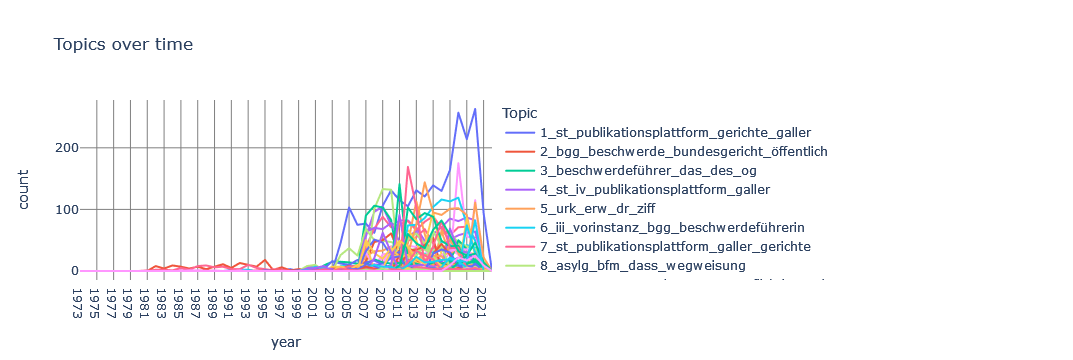

In [ ]:
import plotly.express as px           

fig = px.line(x=plotted_years.tolist(),
              y=topics_by_year_sorted[1:][plotted_years].values.tolist(),
              labels={"value" : "count", "variable": "Topic"  },
              title='Topics over time',
            )
fig.update_layout(xaxis_title="year")

fig.for_each_trace(
    lambda trace: trace.update(name=topic_infos['Name'].iloc[int(trace.name.split("_")[2])+1])
)

fig.update_layout(plot_bgcolor="white")
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='gray')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='gray')

fig.show()

fig.write_html("bertopic_topics_over_time.html")

#### Topic evolution over time

Cool way of visualizing the evolution of topics over time. But the implementation is fairly computationally expensive.

In [ ]:
# Very computationally expensive
topics_over_time = topic_model.topics_over_time(docs_without_outlier, df_topics_filtered, years_without_outliers,evolution_tuning=False, global_tuning=False)

topics_over_time_fig =topic_model.visualize_topics_over_time(topics_over_time, nr_topics=1)
topics_over_time_fig.write_html("topics_over_time_fig.html") # See https://mastermind-escaperoom.ch/assets/bertopic_topics_over_time.html

#### Topic Heatmap

In [ ]:
heatmap_fig= topic_model.visualize_heatmap()
heatmap_fig.write_html("heatmap_bert.html") # See https://mastermind-escaperoom.ch/assets/bert_topic_map.html

#### Topic hierarchy

In [ ]:
hierarchy_fig = topic_model.visualize_hierarchy()
hierarchy_fig.write_html("hieararchy_bert.html") ## See https://mastermind-escaperoom.ch/assets/hieararchy_bert.html

### Evaluation for lawyer

In [ ]:
ids = [20316, 58, 4625, 33578, 22006]

In [ ]:
df_train_de.head()

id  year language                    region canton     legal area  \
0   2  2000       de                    Zürich     zh  insurance law   
1   3  2000       de       Central Switzerland     lu     public law   
2   4  2000       de  Northwestern Switzerland     ag     public law   
3   5  2000       de                       n/a    n/a     public law   
4   6  2000       de                       n/a    n/a      civil law   

       label                                               text  
0  dismissal  A.- Der 1955 geborene V._ war seit 1. Septembe...  
1   approval  Ansprüche nach OHG, hat sich ergeben: A.- X._ ...  
2  dismissal  Art. 4 aBV (Strafverfahren wegen falschen Zeug...  
3   approval  Art. 5 Ziff. 1 EMRK (Haftentlassung), hat sich...  
4  dismissal  Mietvertrag, hat sich ergeben: A.- Die CT Cond...

In [ ]:
topic_model.calculate_probabilities = True

In [ ]:
topics = []
probs_t = []
for id in ids:
  doc = df_train_de['text'][id]
  #doc_text = doc['text'].tolist()#.to_string(index = False)
  print(doc)
  doc_topics, probz = topic_model.transform(doc)
  
  topics.append(doc_topics)
  probs_t.append(probz)

Sachverhalt: A. Mit Verfügung vom 16. Dezember 1996 sprach die IV-Stelle Basel-Stadt der 1948 geborenen J._ rückwirkend ab 1. Februar 1994 eine halbe Invalidenrente zu. Nach formlosen Bestätigungen des Leistungsanspruchs in den Jahren 1999, 2001 und 2004 (sowie verfügungsweiser Neuberechnungen der Rentenhöhe am 25. Februar 2004 zufolge Anspruchs des Ehegatten auf eine Invalidenrente und 4. IV-Revision) leitete die Verwaltung im August 2005 abermals ein Rentenrevisionsverfahren ein. Gestützt auf die Abklärungen im medizinischen, erwerblichen und häuslichen Bereich (u.a. Verlaufsbericht des Dr. med. H._ vom 7. November 2005; Arbeitgeberberichte der Firmen I._ AG vom 16. August 2005 und M._ AG vom 23. August 2005; Abklärungsbericht Haushalt vom 30. Oktober 2006; nach Vorbescheid vom 10. Januar 2007: Gutachten der Dres. med. E._, Facharzt FMH für Rheumatologie/FMH für Innere Medizin, und S._, Facharzt FMH für Psychiatrie und Psychotherapie, vom 9. Mai 2007) teilte die IV-Stelle der Versich

In [ ]:
print(probs_t)

[array([[9.14557105e-01, 1.63126616e-10, 1.14861024e-07, 5.74369737e-09,
        1.76822965e-09, 1.29578257e-09, 6.69704777e-10, 3.38364092e-08,
        1.77893990e-08, 3.14414409e-09, 4.99628953e-06, 1.19810789e-09,
        2.53248006e-08, 5.66774695e-08, 1.76312350e-10, 9.90396597e-10,
        2.61925408e-09, 3.40006421e-09, 7.07030244e-10, 1.06957007e-07,
        5.87168891e-10, 5.43171283e-10, 4.69583388e-06, 2.00745935e-10,
        5.67167579e-08, 1.63755004e-10, 9.50908781e-10, 5.10692772e-10,
        2.53218978e-10, 1.63526552e-07, 4.97004000e-10, 9.65843740e-08,
        8.72318194e-10, 6.83135070e-10, 1.25548938e-09, 6.54062983e-10,
        5.37394991e-10, 6.98337926e-10, 9.26891858e-08, 9.52162638e-09,
        1.77965493e-09, 3.71989849e-10, 4.65109705e-10, 1.37844019e-09,
        9.71640928e-06, 5.07565029e-05, 1.25165023e-09, 1.56737199e-08,
        5.18476717e-11, 1.50335592e-10, 3.99201346e-11, 5.07816457e-09,
        2.21756089e-10, 1.87073527e-07, 3.85884904e-10, 9.61356

In [ ]:
import numpy as np
probability_threshold = 0.01
new_topics = []

for probs in probs_t:
  topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in probs]
  new_topics.append(topics)


In [ ]:
for topic in new_topics:
  #print(topic)
  
  #print(topic_model.get_topic(topic[0]))
  topic_words = []
  for (topic_word, _) in topic_model.get_topic(topic[0]):
    topic_words.append(topic_word)
  print(topic_words)

['iv', 'stelle', 'sozialversicherungsgericht', 'invalidenrente', 'rente', 'zürich', 'verfügung', 'ab', 'vom', 'ganze']
['fuhr', 'svg', 'personenwagen', 'richtung', 'fahrzeug', 'busse', 'uhr', 'art', 'abs', 'er']
['haushalt', 'stelle', 'iv', 'med', 'mutter', 'dr', 'sie', 'bericht', 'invalidenversicherung', 'verheiratet']
['baubewilligung', 'gemeinderat', 'verwaltungsgericht', 'gemeinde', 'baugesuch', 'nr', 'parzelle', 'beschwerde', 'erteilte', 'die']
['basel', 'stadt', 'appellationsgericht', 'mehrfachen', 'verurteilte', 'ihn', 'strafgericht', 'landschaft', 'urteil', 'freiheitsstrafe']


{-1: [('der', 0.004737713817591319),
  ('die', 0.004722454620036199),
  ('und', 0.004520948979818361),
  ('vom', 0.004387272337769133),
  ('des', 0.00435760212973861),
  ('mit', 0.004311210127699615),
  ('auf', 0.004170191964696159),
  ('das', 0.004154690064599917),
  ('in', 0.004123940068601194),
  ('von', 0.004103471691580453)],
 0: [('iv', 0.015657284693438075),
  ('stelle', 0.015484724344316237),
  ('sozialversicherungsgericht', 0.009683675826875003),
  ('invalidenrente', 0.008610892251388023),
  ('rente', 0.008564799468480943),
  ('zürich', 0.008200567044213031),
  ('verfügung', 0.008148789615835553),
  ('ab', 0.0070701798874329),
  ('vom', 0.0069618086605437455),
  ('ganze', 0.006875190104691351)],
 1: [('aufenthaltsbewilligung', 0.018130278531194803),
  ('schweiz', 0.012774143470485633),
  ('geb', 0.012564721894534224),
  ('niederlassungsbewilligung', 0.010329776591523007),
  ('migration', 0.00980893692864603),
  ('heiratete', 0.00908911544851343),
  ('migrationsamt', 0.00818830

In [ ]:
all_topics = topic_model.get_topics()
for i in range(0,50):
  words = []
  for (word,_)in all_topics[i]:
    words.append(word)
  print(words)

['iv', 'stelle', 'sozialversicherungsgericht', 'invalidenrente', 'rente', 'zürich', 'verfügung', 'ab', 'vom', 'ganze']
['aufenthaltsbewilligung', 'schweiz', 'geb', 'niederlassungsbewilligung', 'migration', 'heiratete', 'migrationsamt', 'ehe', 'kantons', 'reiste']
['suva', 'med', 'dr', 'eine', 'bei', 'integritätsentschädigung', 'vom', 'unfallversicherungsanstalt', 'invalidenrente', 'versicherte']
['klägerin', 'beklagte', 'beschwerdegegnerin', 'beschwerdeführerin', 'beklagten', 'ag', 'klage', 'die', 'der', 'handelsgericht']
['steuerverwaltung', 'steuerrekurskommission', 'estv', 'bundessteuer', 'einkommen', 'eidgenössische', 'fr', 'steueramt', 'steuerpflichtigen', 'direkte']
['fuhr', 'svg', 'personenwagen', 'richtung', 'fahrzeug', 'busse', 'uhr', 'art', 'abs', 'er']
['kinder', 'ehefrau', 'ehemann', 'fr', 'unterhaltsbeiträge', 'ehe', 'geb', 'unterhalt', 'monatlich', 'parteien']
['suva', 'folgen', 'unfallversicherungsanstalt', 'versichert', 'leistungen', 'schweizerischen', 'gesetzlichen', '

#Utility (run once)

Written by: Dominik Ummel and Marius Asadauskas

## Preprocessing

In [ ]:
# QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ

from typing import ValuesView
from collections import Counter
# Data preprocessing Utility

!pip install stopwordsiso
import re

# Preprocessing Function
# Parameter: A pandas array containing a col named text
# Return: A pandas array extended by the tow text_processed which contains the preprocessed text
def preprocessing(arr):
  # Remove punctuation
  arr['text_processed'] = \
  arr['text'].map(lambda x: re.sub('[,\.!?\(\):\-\_;/\[\]"]', '', x))
  # Convert the titles to lowercase
  arr['text_processed'] = \
  arr['text_processed'].map(lambda x: x.lower())
  # remove numbers
  arr['text_processed'] = \
  arr['text_processed'].map(lambda x: re.sub('[\d]', '', x))
  # remove multiple chars
  arr['text_processed'] = \
  arr['text_processed'] = arr['text_processed'].str.findall('\w{4,}').str.join(' ')
  # remove french pronouns
  arr['text_processed'] = \
  arr['text_processed'].map(lambda x: re.sub('l\'', ' ', x))
  arr['text_processed'] = \
  arr['text_processed'].map(lambda x: re.sub('d\'', ' ', x))
  arr['text_processed'] = \
  arr['text_processed'].map(lambda x: re.sub('un\'', ' ', x))

  return arr


# Building the stopwords array
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import stopwordsiso

# This function builds an array (type: list) with stopwords in german, french, italian and returns it
def build_stopwords_array():
  stop_words_de = stopwords.words('german')
  stop_words_defr = stop_words_de + stopwords.words('french')
  stop_words_all = stop_words_defr + stopwords.words('italian')
  stopwords_all = stop_words_all + list(stopwordsiso.stopwords(['de', 'fr', 'it']))
  stop_words_all = stop_words_all + ["sachverhalt", "beschwerde", "als", "einen", "war", "mit", "vom", "wies", 
                        "danach", "ferner", "januar", "februar", "märz", "april", "mai", "d'une", "d'un", "aa",
                        "juni", "juli", "august", "september", "oktober", "november", "darauf", "sans", "seit", 
                        "dezember", "bzw", "zudem", "insbesondere", "wegen", "hätten", "sämtlicher", "wurden",
                        "seien", "nahm", "dagegen", "wobei", "wurde", "machte", "ab", "lässt", "weiteren",
                        "kantons", "daran", "dabei", "beim", "holte", "weiterer", "janvier", "février", "worden", 
                        "mars", "avril", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre",
                        "chez", "qu'une", "q'un", "q'une", "dû", "cette", "qu'ils", "qu'il", "plutôt", "quoi",
                        "enfin", "gennaio", "febbraio", "marzo", "aprile", "maggio", "giugno", "luglio", "agosto",
                        "settembre", "ottobre", "novembre", "dicembre", "sowie", "ainsi", "être", "via", "soweit",
                        "wann", "zürich", "bern", "luzern", "schwyz", "schweiz", "aargau", "appenzell",
                        "basel", "freiburg", "genf", "glarus", "graubünden", "jura", "neuchatel", "nidwalden", 
                        "obwalden", "gallen", "schaffhausen", "solothurn", "thurgau", "ticino", "vaud", "wallis", 
                        "urteil", "beschluss", "mehr", "weshalb", "nebst", "entscheid", "verfügung", "freizusprechen",
                        "zuzusprechen", "anzugehen", "obergericht", "kantonsgericht", "bundgesricht", "zweitinstanzlich",
                        "bundesstrafgericht", "vorinstanz", "kantonsgerichts", "bundesgerichts", "obergerichts", "ziffer",
                        "ziff", "kantonale", "verwaltungsgericht", "verwaltungsgerichts", "gemäss", "fest", "stellte",
                        "hiess", "eingeholt", "sprach", "worden", "dent", "nachfolgend", "zurich", "namens", "schuldig",
                        "unschuldig", "seit", "halbe", "seitens", "zuhanden", "bestehen", "auszugehen", "mehrfacher",
                        "urteil", "urteils", "parteien", "meldete", "aufschiebende", "demnach", "laufe", "beklagte",
                        "beklagten", "erhoben", "hingewiesen", "gestellte", "wirkung", "klage", "kläger", "folgen", "darum",
                        "hingegen", "deshalb", "ging", "mussten", "ebenso", "jeweils", "fand", "gemeinde", "kanton"]
  return stop_words_all

# Performs stopword removal on a whole pandas array. The array needs to have a column text_processed
# --> preprocessing needs to be performed first
# returns the array with the stopwords remove from the tect_processed column
def remove_stopwords(arr, stop_words_all):
  stopwords_dict = Counter(stop_words_all)
  for i in range(len(arr)):
    vals = arr.at[i,'text_processed'].split()
    vals = [word for word in vals if word not in stopwords_dict]
    arr.at[i,'text_processed'] = ' '.join(word for word in vals)
  return arr

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     /storage/homefs/rr15t008/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
#Lemmatizer
#!pip install spacy
#!python -m spacy download de

import spacy

def lamma(arr):
  nlp =  spacy.load("de_core_news_sm") #spacy.load('de')
  for i in range(len(arr)):
    doc = nlp.tokenizer(arr[i])
    arr[i] = ' '.join([token.lemma_ for token in doc])

In [ ]:
#Lemmatizer test
nlp = spacy.load('de_core_news_sm')
print(nlp.tokenizer('ist')[0].lemma_)
print(nlp.tokenizer('Blumen')[0].lemma_)
print(nlp.tokenizer('blumen')[0].lemma_)
print(nlp.tokenizer('Zins')[0].lemma_)


In [ ]:
# Trigrams
from nltk import ngrams

# Helper function to creat trigrams
def returnTrigrams(arr):
  try:
    return list(ngrams(arr, 3))
  except(StopIteration, RuntimeError):
    return []

# Helper function to create trigrams
def tupToStr(arr):
  for i in range(0, len(arr)):
    arr[i] = ' '.join(arr[i])
  return arr

# Creates an array with the text as trigrams
# Parameter is a pandas array containing a clomun text_processed
def create_trigrams(arr):
  proc_text = arr['text_processed'].values.tolist()
  proc_text_split = [d.split() for d in proc_text]

  proc_text_trigrams = proc_text_split
  for i in range(0,len(proc_text_split)):
    proc_text_trigrams[i] = tupToStr(returnTrigrams(proc_text_split[i]))

  return proc_text_trigrams

# LDA

Written by: Dominik Ummel

In [ ]:
import pandas as pd

df_train = pd.read_json("train.jsonl", lines=True)
df_test = pd.read_json("test.jsonl", lines=True)
df_val = pd.read_json("val.jsonl", lines=True)

In [ ]:
Dataset = [df_train, df_test, df_val]
for arr in Dataset:
  arr = preprocessing(arr)

In [ ]:
df_train = df_train.loc[df_train['language'] == "de"]

df_train = preprocessing(df_train)
swa = build_stopwords_array()
df_train = remove_stopwords(df_train, swa)

In [ ]:

df_val.head()
#df_val['text_processed'][0]
#df_val.head()
#df_val.loc[df_val['language'] == "fr"]['text_processed']
#df_val['text_processed'][4800]

id  year language               region canton  legal area      label  \
0  48757  2015       de    Espace Mittelland     be   penal law  dismissal   
1  48758  2015       de               Zürich     zh  social law  dismissal   
2  48760  2015       de               Zürich     zh  social law  dismissal   
3  48761  2015       de               Zürich     zh  social law  dismissal   
4  48762  2015       de  Central Switzerland     zg  social law  dismissal   

                                                text  \
0  Sachverhalt: A. X._ war bei der Krankenversich...   
1  Sachverhalt: A. Der 1961 geborene A._ wurde na...   
2  Sachverhalt: A. A.a. Mit Verfügung vom 9. Febr...   
3  Sachverhalt: A. A._, geboren 1963, erlitt am 2...   
4  Sachverhalt: A. B._ war seit 25. September 199...   

                                      text_processed  
0  sachverhalt krankenversicherung taggeldversich...  
1  sachverhalt geborene erlittenen unfall erfolgr...  
2  sachverhalt verfügung bejahte wirtschaft arbei...  
3  sachverhalt geboren erlitt unfall bezog ganze ...  
4  sachverhalt seit lehrbeauftragter musik gemein...

In [ ]:
# Train the model
import gensim.corpora as corpora

proc_text = df_val['text_processed'].values.tolist()
proc_text_split = [d.split() for d in proc_text]

dictionary = corpora.Dictionary(proc_text_split)
corpus = [dictionary.doc2bow(a) for a in proc_text_split]
#print(corpus[:1][0][:30])

import gensim
from pprint import pprint
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"beschwerde" + 0.011*"fr" + 0.009*"entscheid" + 0.006*"beantragt" + '
  '0.006*"verfügung" + 0.005*"zürich" + 0.005*"sachverhalt" + 0.005*"urteil" + '
  '0.004*"aufzuheben" + 0.004*"ivstelle"'),
 (1,
  '0.020*"fr" + 0.016*"beschwerde" + 0.010*"urteil" + 0.008*"ag" + '
  '0.007*"sachverhalt" + 0.007*"beantragt" + 0.006*"aufzuheben" + 0.006*"art" '
  '+ 0.006*"verfügung" + 0.005*"obergericht"'),
 (2,
  '0.020*"beschwerde" + 0.013*"fr" + 0.010*"entscheid" + 0.008*"obergericht" + '
  '0.007*"sachverhalt" + 0.007*"verfügung" + 0.006*"beantragt" + 0.006*"art" + '
  '0.005*"sache" + 0.005*"bundesgericht"'),
 (3,
  '0.019*"beschwerde" + 0.015*"verfügung" + 0.008*"ivstelle" + '
  '0.006*"sachverhalt" + 0.006*"entscheid" + 0.006*"urteil" + 0.005*"fr" + '
  '0.005*"ag" + 0.005*"beantragt" + 0.005*"art"'),
 (4,
  '0.018*"beschwerde" + 0.012*"fr" + 0.011*"urteil" + 0.008*"ag" + '
  '0.007*"sachverhalt" + 0.006*"zürich" + 0.006*"entscheid" + '
  '0.005*"verfügung" + 0.005*"beantragt" +

In [ ]:
#using trigrams

# Train the model
import gensim.corpora as corpora

proc_text_trigrams = create_trigrams(df_val)


dictionary = corpora.Dictionary(proc_text_trigrams)
corpus = [dictionary.doc2bow(a) for a in proc_text_trigrams]
#print(corpus[:1][0][:30])

import gensim
from pprint import pprint
num_topics = 5
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
df_val['text_processed'][0]

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

topics_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(topics_vis)



/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# NMF

Written by: Marius Asadauskas

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
i = 0
while i < len(df_train):
  if df_train['language'][i] != 'de':
    df_train = df_train[:i:]
  else:
    i += 1

In [ ]:
df_train.head()

id  year language                    region canton     legal area  \
0   2  2000       de                    Zürich     zh  insurance law   
1   3  2000       de       Central Switzerland     lu     public law   
2   4  2000       de  Northwestern Switzerland     ag     public law   
3   5  2000       de                       n/a    n/a     public law   
4   6  2000       de                       n/a    n/a      civil law   

       label                                               text  \
0  dismissal  A.- Der 1955 geborene V._ war seit 1. Septembe...   
1   approval  Ansprüche nach OHG, hat sich ergeben: A.- X._ ...   
2  dismissal  Art. 4 aBV (Strafverfahren wegen falschen Zeug...   
3   approval  Art. 5 Ziff. 1 EMRK (Haftentlassung), hat sich...   
4  dismissal  Mietvertrag, hat sich ergeben: A.- Die CT Cond...   

                                      text_processed  
0  a der  geborenewar seit  september  hauptberuf...  
1  ansprüche nach ohg hat sich ergebenx wurde jul...  
2  art  abv strafverfahren wegen falschen zeugnis...  
3  art  ziff  emrk haftentlassung hat sich ergebe...  
4  mietvertrag hat sich ergebendiecondor treuhand...

In [ ]:
# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=50)

# Fit and transform
X = vect.fit_transform(df_train.text_processed)

In [ ]:
# Create an NMF instance: model
# the 10 components will be the topics
model = NMF(n_components=10, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [ ]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa       aaa      aaba     aarau    aargau  aargauentscheid  \
0  0.000418  0.001288  0.000000  0.004702  0.000000         0.000000   
1  0.009127  0.008882  0.000000  0.000000  0.000000         0.000131   
2  0.001022  0.001086  0.022294  0.000196  0.000000         0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.163736         0.017565   
4  0.000074  0.000000  0.000000  0.046811  0.329645         0.000000   
5  0.042929  0.000000  0.000000  0.000000  0.000000         0.000000   
6  0.000000  0.000000  0.000000  0.000000  0.015776         0.016925   
7  0.000000  0.000000  0.000000  0.009524  0.255798         0.001813   
8  0.000000  0.000037  0.000000  0.000000  0.000000         0.000000   
9  0.000000  0.001743  0.000190  0.000000  0.000000         0.000000   

   aargauer  aargauische  aargauischen      aart  ...  überwiegender  \
0  0.002154     0.003445      0.006738  0.000795  ...       0.002669   
1  0.000000     0.000000      0.000005  0.000000  ...       0.000000   
2  0.000000     0.000005      0.000081  0.000000  ...       0.000000   
3  0.000000     0.000690      0.000000  0.000000  ...       0.000000   
4  0.007656     0.001608      0.001567  0.026708  ...       0.000000   
5  0.000000     0.000000      0.000000  0.000000  ...       0.000000   
6  0.000000     0.000000      0.000041  0.000000  ...       0.024421   
7  0.002643     0.003823      0.005012  0.001776  ...       0.000000   
8  0.000000     0.000000      0.000000  0.000000  ...       0.000000   
9  0.000000     0.000000      0.000000  0.000000  ...       0.000000   

   überwies  überwiesen  überwiesenen     üblen     übler  üblichen    übrige  \
0  0.031995    0.026330      0.004931  0.000000  0.004812  0.008339  0.006544   
1  0.000000    0.000000      0.000000  0.000000  0.000000  0.000002  0.000000   
2  0.000000    0.000000      0.000003  0.000000  0.000000  0.000000  0.000002   
3  0.000760    0.000017      0.000118  0.000000  0.000000  0.000000  0.000000   
4  0.005564    0.008518      0.000406  0.034635  0.019472  0.000000  0.000000   
5  0.000000    0.000000      0.000006  0.000000  0.000000  0.000017  0.000000   
6  0.002245    0.000000      0.000000  0.000000  0.000000  0.000651  0.000000   
7  0.031574    0.003934      0.000000  0.000000  0.000000  0.000410  0.000000   
8  0.000000    0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
9  0.000000    0.000000      0.000000  0.000000  0.000000  0.000003  0.000000   

    übrigen      übte  
0  0.060940  0.003228  
1  0.000000  0.000000  
2  0.000000  0.000011  
3  0.003139  0.007557  
4  0.051701  0.000000  
5  0.000000  0.000000  
6  0.012638  0.001900  
7  0.004315  0.000000  
8  0.000000  0.000000  
9  0.000000  0.000000  

[10 rows x 18154 columns]

In [ ]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

In [ ]:
my_document = pd.DataFrame(nmf_features).loc[55]
my_document

0    0.051474
1    0.000621
2    0.000000
3    0.001743
4    0.000000
5    0.000000
6    0.000000
7    0.030764
8    0.000000
9    0.000000
Name: 55, dtype: float64

# Contextualized Topic Model

Written by: Dominik Ummen and Marius Asadauskas

In [ ]:
%%capture
!pip install contextualized-topic-models
!pip install pyldavis

In [ ]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import pandas as pd

In [ ]:
#df_val = pd.read_json("val.jsonl", lines=True)
df_val = df_train_de
#df_val = pd.read_json("test.jsonl", lines=True)

In [ ]:
len(processed)

8272

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
#preprocessing for df_train

#df_val = df_val.loc[df_val['language'] == "de"]
#df_val = df_val.drop_duplicates(subset=['text'])

#df_val.reset_index(inplace=True)

df_val = preprocessing(df_val)
swa = build_stopwords_array()
df_val = remove_stopwords(df_val, swa)

In [ ]:
df_val.to_pickle("./df_val_preprocessed.pkl") 

In [ ]:
df_val = pd.read_pickle("./df_val_preprocessed.pkl")

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
sp = WhiteSpacePreprocessing(df_val['text_processed'], stopwords_language='german', vocabulary_size=2200)
processed, unprocessed, vocab, dummy = sp.preprocess()

/storage/homefs/rr15t008/.local/lib/python3.9/site-packages/contextualized_topic_models/utils/preprocessing.py:24: UserWarning: WhiteSpacePreprocessing is deprecated and will be removed in future versions.Use WhiteSpacePreprocessingStopwords.
  warnings.warn("WhiteSpacePreprocessing is deprecated and will be removed in future versions."


In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
#lamma(processed)
# Was skipped

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
tp = TopicModelDataPreparation("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unprocessed, text_for_bow=processed)

/storage/homefs/rr15t008/.local/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 114567 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1580 [00:00<?, ?it/s]

In [ ]:
import pickle

# Caching tp and training dataset
with open('tp.pkl', 'wb') as handle:
    pickle.dump(tp, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('training_dataset.pkl', 'wb') as handle:
    pickle.dump(training_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
tp.vocab
len(tp.vocab)

2200

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=100, num_epochs=10, num_data_loader_workers=4) # Adjust num workers to amount of cpu cores
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [3159470/3159470]	Train Loss: 4823.7545929875105	Time: 0:00:58.230486: : 10it [09:40, 58.02s/it]
Sampling: [20/20]: : 20it [16:55, 50.77s/it]


In [ ]:
with open('ctm.pkl', 'wb') as handle:
    pickle.dump(ctm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
topics = ctm.get_topic_lists(5)
for topic in topics:
  print(' '.join(topic))

lanka beschwerdefuhrer ltte beschwerdefuhrers asylg
estv mehrwertsteuer beschwerdefuhrerin steuerpflichtige hrerin
auszug kind lehre kindes gemeinsam
diverse seiten bild relevant aspekte
bundesgericht feststellungen willkurlich kritik tribunal
suva spital unfallversicherung berichte gesundheit
migration anag bundesrichter offentlichrechtlichen abteilung
strafverfahren untersuchungshaft staatsanwaltschaft stpo haft
gesuchsgegnerin klagerin vorlaufige gesuchstellerin handelsgericht
verfahrensbeteiligte tribunal mitgeteilt einsicht tribunale
pflichtigen steueramt aktien liegenschaften verkauf
unten mitte vorstehend arzte unterschrift
verfahren schkg rechtsoffnung bezirksgericht betreibung
diverse verfahrensbeteiligte einsicht seiten bild
kesb privatklagerin gewalt beschwerdefuhrerin vater
italien dubliniiivo asylg asylgesuch bundesverwaltungsgericht
beilage publikation mitteilung zulassigkeit richten
einsicht verfahrensbeteiligte diverse mitgeteilt seiten
hiervor beweiswert beschwerdefuhr

In [ ]:
#predicting the selected rulings
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions
import numpy as np
topic_number = np.argmax(topics_predictions[20316]) # get the topic id of the first document
ctm.get_topic_lists(5)[topic_number]

Sampling: [5/5]: : 5it [02:52, 34.40s/it]


['diverse', 'auszug', 'seiten', 'patienten', 'universita']

In [ ]:
text1 = df_train['text_processed'][20316]
text2 = df_train['text_processed'][58]
text3 = df_train['text_processed'][4625]
text4 = df_train['text_processed'][33578]
text5 = df_train['text_processed'][22006]

to_predict = [text1, text2, text3, text4, text5]

sp = WhiteSpacePreprocessing(to_predict)
testing_processed, testing_unprocessed, testing_vocab, dummy = sp.preprocess()

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/preprocessing.py:24: UserWarning: WhiteSpacePreprocessing is deprecated and will be removed in future versions.Use WhiteSpacePreprocessingStopwords.
  warnings.warn("WhiteSpacePreprocessing is deprecated and will be removed in future versions."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
testing_dataset = tp.transform(text_for_contextual=testing_unprocessed, text_for_bow=testing_processed)

# n_sample how many times to sample the distribution (see the doc)
distribution = ctm.get_doc_topic_distribution(testing_dataset, n_samples=20) # returns a (n_documents, n_topics) matrix with the topic distribution of each document

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 147 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling: [20/20]: : 20it [00:07,  2.68it/s]


In [ ]:
import numpy as np
topic_number = np.argmax(distribution[1])
ctm.get_topic_lists(5)[topic_number]

['berufung', 'klagerin', 'zins', 'betrag', 'bezahlen']

In [ ]:
#topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions
#import numpy as np
topic_number = np.argmax(topics_predictions[33570]) # get the topic id of the first document
ctm.get_topic_lists(5)[topic_number]

In [ ]:
len(df_train['text_processed'])

35458

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=20)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [20/20]: : 20it [16:52, 50.60s/it]
/storage/homefs/rr15t008/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
#from google.colab import files
vis.save_html(ctm_pd, 'ctm.html')
#files.download('ctm.html') 

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
training_dataset = tp.transform(text_for_contextual=df_val['text'], text_for_bow=df_val['text_processed'])

/storage/homefs/rr15t008/.local/lib/python3.9/site-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 276934 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1625 [00:00<?, ?it/s]

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
# adding the predictions for all rulings
#topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions
import numpy as np

topics_predictions = ctm.get_doc_topic_distribution(training_dataset, n_samples=5) # get all the topic predictions

all_topics = ctm.get_topic_lists(5)
for i in range(len(all_topics)):
  all_topics[i] = '_'.join(all_topics[i])

topic_list = []

for i in range(len(topics_predictions)):
  topic_number = np.argmax(topics_predictions[i]) # get the topic id of the first document
  topic_list.append(all_topics[topic_number])

df_val['prediction'] = topic_list

Sampling: [5/5]: : 5it [04:19, 51.90s/it]


In [ ]:
df_val['date'].head()

0    2009-08-21
1    2019-11-05
2    1995-10-04
3    2007-12-28
4    2016-06-23
Name: date, dtype: object

-> This does not work with the current dataset, but could be an interesting evaluation

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQ
#topics by label
topics_by_label = pd.DataFrame(np.zeros((len(all_topics),2)),columns=['dismissal', 'approval'],index=all_topics)

for i in range(len(df_val)):
  topics_by_label.loc[df_val['prediction'][i]][df_val['label'][i]] += 1

topics_by_label['percentage_approved'] = topics_by_label['approval']
for i in range(len(topics_by_label)):
  topics_by_label['percentage_approved'][i] = topics_by_label['approval'][i]/(topics_by_label['approval'][i]+topics_by_label['dismissal'][i])*100

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ--> download thsi dataframe
topics_by_label

In [ ]:
df_val['year'] = df_val['date'].astype(str).map(lambda x: x.split('-')[0])

In [ ]:
df_val['year']

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ
#topics by year
years = df_val['year'].unique()
for i in range(len(years)):
  years[i] = str(years[i])

topics_by_year = pd.DataFrame(np.zeros((len(all_topics),len(years))),columns=years,index=all_topics)

for i in range(len(df_val)):
  topics_by_year.loc[df_val['prediction'][i], df_val['year'][i]] += 1

In [ ]:
#QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ--> download his dataframe
topics_by_year

In [ ]:
topics_by_year.to_csv("topics_by_year.csv")

# Octis

Written by Marius Asadauskas

In [ ]:
%%capture
pip install octis

In [ ]:
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

In [ ]:
df_train = df_train.loc[df_train['language'] == "de"]
# Preprocess
df_train = preprocessing(df_train)
swa = build_stopwords_array()
df_train = remove_stopwords(df_train, swa)

In [ ]:
import numpy as np

temp = pd.unique(df_train['text_processed'])
rem = []
for i in range(len(temp)):
  if temp[i] == '' or i % 2 == 0:
    rem.append(i)
temp = np.delete(temp, rem)
temp = temp[:1000]
temp = pd.DataFrame(temp, columns = ['text_processed'])

In [ ]:
temp['text_processed'].to_csv('corpus.tsv', sep='\t', header=False, index=False)

dataset = Dataset()
dataset.load_custom_dataset_from_folder('.', multilabel=False)

In [ ]:
from octis.models.LDA import LDA

model = LDA(num_topics=20)  # Create model
model_output = model.train_model(dataset) # Train the model

In [ ]:
npmi = Coherence(texts=dataset.get_corpus(), topk=10, measure='c_npmi')
topic_diversity = TopicDiversity(topk=10)

In [ ]:
# Retrieve metrics score
topic_diversity_score = topic_diversity.score(model_output)
print("Topic diversity: " + str(topic_diversity_score))

npmi_score = npmi.score(model_output)
print("Coherence: " + str(npmi_score))

Topic diversity: 0.19
Coherence: 0.05908733957651061


In [ ]:
topics = model._get_topics_words(5)
for t in topics:
  print(" ".join(t))

verfahren dispositivziffer departement vertretung kosten
ivstelle invalidenrente erhobene öffentlichrechtlichen invalidenversicherung
zuzüglich zins klägerin garage anhang
zins klägerin zuzüglich zusatzvereinbarung bestehenden
gesetzeskonformen vertreibt beantragt bundesgericht ivstelle
besuchsrecht bundesgericht unbegleiteten verfahren sorge
ausgleichszahlung bundesgericht beschwerdegegner güterrechtliche besuchsrecht
euro verfahren zins employment salary
beschuldigte bundesgericht bausektion beschwerdeführerin beschwerdeführer
oberrichter zuzüglich strafkammer ausstandsgesuch klägerin
aufenthaltsbewilligung club migrationsamt regierungsstatthalteramt aufzuheben
weisung einspracheverfahren mobile krankenversichert sommerferien
ivstelle angelegenheiten öffentlichrechtlichen invalidenrente suva
euro paid amount period contract
anklagekammer oberrichterin strafverfahrens strafverfahren ermächtigung
einsicht datensammlungen beantragt öffentlichrechtlichen bundesgericht
suva universität ei

In [ ]:
topics = model._get_topics_words(5)

In [ ]:
# We find the rulings we search for
top = []
for i in range(len(df_train)):
  if df_train.at[i, 'id'] in [67, 5506, 20316, 27635, 45771]:
    text = df_train.at[i, 'text_processed']
    hits = []
    for i in range(50):
      match = 0
      for word in topics[i]:
        match += text.count(word)
      hits.append(match)
    top.append(np.argmax(hits))

In [ ]:
for t in top:
  print('Topic ' + str(t) + ': ' + ' '.join(topics[t]))

Topic 0: beklagten klägerin berufung beklagte klage gericht forderung bezirksgericht rechtsbegehren uhren
Topic 36: rente ivstelle invalidenversicherung einspracheentscheid bericht verwaltungsgerichtsbeschwerde medizin erhobene meldete halbe
Topic 14: gemeinde rekurskommission flughafen uvek stellte fest gesuch erhoben umwelt departement
Topic 0: beklagten klägerin berufung beklagte klage gericht forderung bezirksgericht rechtsbegehren uhren
Topic 5: gemeinderat parzelle regierungsrat baubewilligung baugesuch sinne bewilligung grundstück parzellen bundesgericht


In [ ]:
print(len(temp))

15983


In [ ]:
from octis.models.NMF import NMF

model = NMF(num_topics=50)  # Create model
model_output = model.train_model(dataset) # Train the model

In [ ]:
topics = model._get_topics_words(5)
for t in topics:
  print(" ".join(t))

beklagten klägerin berufung beklagte klage
beschwerdeführerin beschwerdegegnerin schiedsgericht gemäss beantragt
invalidenrente ganze sprach invaliditätsgrad halbe
staatsanwaltschaft stgb kantonsgericht anklagekammer anklage
ausgleichskasse verwaltungsgerichtsbeschwerde höhe beiträge schadenersatz
gemeinderat parzelle regierungsrat baubewilligung baugesuch
kosten helsana rekurskommission ziffer nachfolgend
beklagte kläger berufung klage beklagten
suva klinik bericht leistungen beschwerden
unentgeltliche rechtspflege gesuch verbeiständung unentgeltlichen
wirkung stiftung aufschiebende klage beantragt
klägerin zins bezahlen beklagte verpflichten
ziff sinne aufzuheben gemäss dispositivs
gemäss untersuchungshaft staatsanwaltschaft bezirksgericht berufung
gemeinde rekurskommission flughafen uvek stellte
beschwerdegegnerin beschwerdeführer obergericht beschwerdeführers vorinstanz
klägerin beklagte parteien berufung schreiben
sache zurückzuweisen vorinstanz aufzuheben bundesgericht
einsprache

In [ ]:
print(Doc_Mat.shape)

(50, 31970)


In [ ]:
t = 0
for i in ids:
  probs = model.trained_model.get_document_topics(model.id_corpus[i], minimum_probability=0)
  idx = np.argmax(probs, axis = 0)[-1]
  t = probs[idx][0]
  print('Topic ' + str(t) + ': ' + ' '.join(topics[t]))

Topic 16: kläger beklagten beklagte berufung zins
Topic 43: ivstelle invalidenversicherung invalidenrente rente meldete
Topic 41: verwaltungsgericht gemeinderat baubewilligung verwaltungsgerichts beantragen
Topic 39: sprach mehrfachen schuldig verurteilte jahren
Topic 22: stadt bundesgericht aufhebung angefochtenen erhoben


In [ ]:
top = np.argmax(Doc_Mat[:, ids], axis = 0)
for t in top:
  print('Topic ' + str(t) + ': ' + ' '.join(topics[t]))

In [ ]:
# Retrieve metrics score
topic_diversity_score = topic_diversity.score(model_output)
print("Topic diversity: "+str(topic_diversity_score))

npmi_score = npmi.score(model_output)
print("Coherence: "+str(npmi_score))

Topic diversity: 0.605
Coherence: 0.1096634961117277


In [ ]:
from octis.models.NeuralLDA import NeuralLDA

model = NeuralLDA(num_topics=20, use_partitions=False)  # Create model
model_output = model.train_model(dataset) # Train the model

In [ ]:
for t in model_output['topics']:
  print(" ".join(t[:5]))

rechts erlitt unfallversicherung links angestellt
ivstelle öffentlichrechtlichen angelegenheiten invalidenrente erhobene
ausstandsbegehren materiellen rechtsvertreters vollständige verschiedener
steuerverwaltung estv eidgenössische bank zusammenhang
letztinstanzlich wirtschaftliche sandte betraf unabhängig
eingegangen zuzuerkennen entrichten arbeitsverhältnisses festlegung
aufzuheben beantragt bundesgericht obergericht verfahren
strafsachen tagessätzen geldstrafe bedingten freiheitsstrafe
verfügten angegeben entschädigungen sachverhaltsabklärung entsiegelungsgesuch
post abzuändern vorliege dienste akteneinsicht
festsetzung äussert längstens früheren therapie
erhebung geburt bremgarten praxis begleitung
baugesuch auflagen baubewilligung grundstücks gemeinderat
sozialbehörde jährlich berichtigung verfahrensrechtlicher versehen
ermächtigung zeigte sozialen fristgerecht italien
entsprechender vorerst ausgerichtet materiell abgelehnt
zweiter nimmt altersrente reduziert vereinigung
erlassen 

In [ ]:
from octis.models.CTM import CTM

model = CTM(num_topics=10, num_epochs=30, inference_type='zeroshot', bert_model="bert-base-nli-mean-tokens")

In [ ]:
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer

In [ ]:
npmi = Coherence(texts=dataset.get_corpus())
search_space = {"num_layers": Categorical({1, 2, 3}), 
                "num_neurons": Categorical({100, 200, 300}),
                "activation": Categorical({'sigmoid', 'relu', 'softplus'}), 
                "dropout": Real(0.0, 0.95)
}

In [ ]:
optimizer=Optimizer()
optimization_result = optimizer.optimize(
    model, dataset, npmi, search_space, number_of_call=30, 
    model_runs=1, save_models=False)

# Visualization and Evaluation

Done by all of us usually outside of colab, since plotly refused to work most of the time